In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

## Data Exploration

In [3]:
print(f"Shape of the training inputs: {X_train.shape}")
print(f"Shape of the training labels: {y_train.shape}")
print(f"Shape of the testing inputs: {X_test.shape}")
print(f"Shape of the testing labels: {y_test.shape}")

Shape of the training inputs: (60000, 28, 28)
Shape of the training labels: (60000,)
Shape of the testing inputs: (10000, 28, 28)
Shape of the testing labels: (10000,)


Training: 60000 images, 28x28 grid
Testing: 10000 images, 28x28 grid

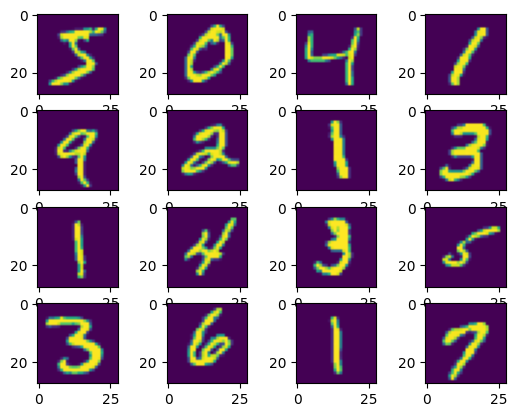

In [4]:
fig, axs = plt.subplots(4, 4)
cnt = 0
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(X_train[cnt])
        cnt += 1

In [5]:
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

In [6]:
X_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

## Our Standard Neural Network

In [7]:
class NeuralNetwork:
    def __init__(self, layer_sizes, lr = 0.01):
        self.layer_sizes = layer_sizes
        self.lr = lr
        self.num_layers = len(layer_sizes)
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        
        # Xavier/Glorot initialization for better convergence
        for i in range(self.num_layers - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def relu(self, z):
        return np.maximum(0,z)

    def relu_drvtv(self, z):
        return (z > 0).astype(float)

    def softmax(self, z):
        # Subtract max for numerical stability
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        activations = [X]
        z_values = []

        # Forward through hidden layers
        for i in range(self.num_layers - 2):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i] 
            a = self.relu(z)
            z_values.append(z)
            activations.append(a)

        # Output layer
        z = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        a = self.softmax(z)
        z_values.append(z)
        activations.append(a)

        return activations, z_values

    def compute_loss(self, y_pred, y_true):
        # Cross entropy loss
        m = y_true.shape[0]
        epsilon = 1e-8
        loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
        return loss

    def backwards(self, X, y_true, activations, z_values):
        m = X.shape[0]
        weight_grads = []
        bias_grads = []

        # Output layer gradient (softmax + cross-entropy)
        delta = activations[-1] - y_true

        # Backpropagate through layers
        for i in range(len(self.weights)-1, -1, -1):
            dw = np.dot(activations[i].T, delta) / m
            db = np.sum(delta, axis = 0, keepdims = True) / m

            weight_grads.insert(0, dw) # optimize by using a deque? - each index holds all grads for that layer
            bias_grads.insert(0, db) 

            # Propogate error to next layer (if not input)
            if i > 0:
                delta = (np.dot(delta, self.weights[i].T) * self.relu_drvtv(z_values[i-1]))

        return weight_grads, bias_grads

    def update_paramaters(self, weight_grads, bias_grads):
        # Gradient Descent
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * weight_grads[i]
            self.biases[i] -= self.lr * bias_grads[i]

    def train(self, X_train, y_train, X_val=None, y_val=None, 
              epochs=100, batch_size=32, verbose=True):
        history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
        n_samples = X_train.shape[0]

        for epoch in range(epochs):
            # Shuffle training data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            # Mini-batch training
            epoch_loss = 0
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                activations, z_values = self.forward(X_batch)
                loss = self.compute_loss(activations[-1], y_batch)
                epoch_loss += loss
                weight_grads, bias_grads = self.backwards(X_batch, y_batch, 
                                                         activations, z_values)
                self.update_paramaters(weight_grads, bias_grads)

            # Training metrics
            train_pred = self.predict(X_train)
            train_acc = np.mean(train_pred == np.argmax(y_train, axis=1))
            avg_loss = epoch_loss / (n_samples // batch_size)

            history["train_loss"].append(avg_loss)
            history["train_acc"].append(train_acc)
        
            if X_val is not None and y_val is not None:
                val_pred = self.predict(X_val)
                val_acc = np.mean(val_pred == np.argmax(y_val, axis=1))
                activations_val, _ = self.forward(X_val)
                val_loss = self.compute_loss(activations_val[-1], y_val)
                
                history["val_loss"].append(val_loss)
                history["val_acc"].append(val_acc)
                
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs} - "
                          f"Loss: {avg_loss:.4f} - Acc: {train_acc:.4f} - "
                          f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
            else:
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs} - "
                          f"Loss: {avg_loss:.4f} - Acc: {train_acc:.4f}")
        
        return history

    def predict(self, X):
        activations, z_values = self.forward(X)
        return np.argmax(activations[-1], axis = 1)

    def predict_proba(self, X):
        activations, z_values = self.forward(X)
        return activations[-1] 

## Model Building

In [8]:
### Training on MNIST with Standard NN

In [9]:
X_train_flat = X_train.reshape(60000, 28*28)
X_test_flat = X_test.reshape(10000, 28*28)

# One-hot encode labels
y_train_onehot = np.eye(10)[y_train]  # (60000,) -> (60000, 10)
y_test_onehot = np.eye(10)[y_test]    # (10000,) -> (10000, 10)

input_nodes = 28*28
output_nodes = 10

In [10]:
nn = NeuralNetwork(
    layer_sizes=[input_nodes, 128, 64, output_nodes],
    lr=0.01
)

In [11]:
nn.train(X_train_flat, y_train_onehot)

Epoch 10/100 - Loss: 0.1741 - Acc: 0.9522
Epoch 20/100 - Loss: 0.1036 - Acc: 0.9719
Epoch 30/100 - Loss: 0.0704 - Acc: 0.9817
Epoch 40/100 - Loss: 0.0503 - Acc: 0.9881
Epoch 50/100 - Loss: 0.0368 - Acc: 0.9916
Epoch 60/100 - Loss: 0.0272 - Acc: 0.9948
Epoch 70/100 - Loss: 0.0203 - Acc: 0.9970
Epoch 80/100 - Loss: 0.0152 - Acc: 0.9982
Epoch 90/100 - Loss: 0.0115 - Acc: 0.9989
Epoch 100/100 - Loss: 0.0089 - Acc: 0.9993


{'train_loss': [np.float64(0.9579364149786856),
  np.float64(0.37058858417333285),
  np.float64(0.3093140128167099),
  np.float64(0.275923857040382),
  np.float64(0.25123957109222284),
  np.float64(0.23104132181794937),
  np.float64(0.21388082331127112),
  np.float64(0.1991811105157317),
  np.float64(0.18589542183280944),
  np.float64(0.17411225924153653),
  np.float64(0.16368582685784236),
  np.float64(0.15408539966850218),
  np.float64(0.1457729049305063),
  np.float64(0.13800954913474162),
  np.float64(0.13109710445300943),
  np.float64(0.1244801259823144),
  np.float64(0.11870172756942587),
  np.float64(0.11329026602476398),
  np.float64(0.1082424069777314),
  np.float64(0.10363301444012449),
  np.float64(0.09932670232982233),
  np.float64(0.0952579487537569),
  np.float64(0.091425082080053),
  np.float64(0.08795455329397729),
  np.float64(0.08454265658359383),
  np.float64(0.08137507923488309),
  np.float64(0.07822997034836607),
  np.float64(0.0755378750580142),
  np.float64(0.072

### Testing on MNIST with Standard NN

In [12]:
y_true = y_test_onehot
test_pred = nn.predict(X_test_flat)
test_acc = np.mean(test_pred == np.argmax(y_true, axis=1))

In [13]:
test_acc 

np.float64(0.9753)

Quite abit lower than the final training accuracy - likely overfit

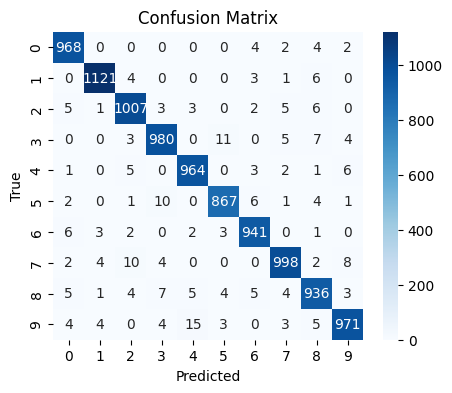

In [14]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Convolutional Neural Network

* Add convolutional layers
* Add pooling layers
* Add flatten layers

In [15]:
class ConvolutionalNeuralNetwork:
    def __init__(self, input_shape, lr = 0.01):
        self.input_shape = input_shape # (Height, Width, Channels)
        self.lr = lr
        self.layers = []
        self.trainable_layers = []

    def __str__(self):
        summary = "=" * 70 + "\n"
        summary += "CNN Model Architecture Summary\n"
        summary += "=" * 70 + "\n"
        summary += f"Input Shape: {self.input_shape}\n"
        summary += f"Learning Rate: {self.lr}\n"
        summary += "-" * 70 + "\n"
        
        current_shape = self.input_shape
        total_params = 0
        
        for i, layer in enumerate(self.layers):
            layer_type = layer["type"]
            summary += f"Layer {i+1}: {layer_type.upper()}\n"
            
            if layer_type == "conv":
                f = layer["filter_size"]
                n_filters = layer["num_filters"]
                stride = layer["stride"]
                padding = layer["padding"]
                
                # Calculate output shape
                h_out = (current_shape[0] + 2*padding - f) // stride + 1
                w_out = (current_shape[1] + 2*padding - f) // stride + 1
                output_shape = (h_out, w_out, n_filters)
                
                # Calculate parameters
                if layer["weights"] is not None:
                    params = layer["weights"].size + layer["bias"].size
                    total_params += params
                    summary += f"  Filters: {n_filters}, Size: {f}x{f}, Stride: {stride}, Padding: {padding}\n"
                    summary += f"  Parameters: {params:,}\n"
                
                summary += f"  Input:  {current_shape}\n"
                summary += f"  Output: {output_shape}\n"
                current_shape = output_shape
                
            elif layer_type == "pool":
                pool_size = layer["pool_size"]
                stride = layer["stride"]
                mode = layer["mode"]
                
                h_out = (current_shape[0] - pool_size) // stride + 1
                w_out = (current_shape[1] - pool_size) // stride + 1
                output_shape = (h_out, w_out, current_shape[2])
                
                summary += f"  Pool Size: {pool_size}x{pool_size}, Stride: {stride}, Mode: {mode}\n"
                summary += f"  Input:  {current_shape}\n"
                summary += f"  Output: {output_shape}\n"
                current_shape = output_shape
                
            elif layer_type == "relu":
                summary += f"  Input/Output: {current_shape}\n"
                
            elif layer_type == "flatten":
                flattened_size = current_shape[0] * current_shape[1] * current_shape[2]
                output_shape = (flattened_size,)
                
                summary += f"  Input:  {current_shape}\n"
                summary += f"  Output: {output_shape}\n"
                current_shape = output_shape
                
            elif layer_type == "dense":
                output_size = layer["output_size"]
                activation = layer["activation"]
                
                # Calculate parameters
                if layer["weights"] is not None:
                    params = layer["weights"].size + layer["bias"].size
                    total_params += params
                    summary += f"  Units: {output_size}, Activation: {activation}\n"
                    summary += f"  Parameters: {params:,}\n"
                
                summary += f"  Input:  {current_shape}\n"
                summary += f"  Output: ({output_size},)\n"
                current_shape = (output_size,)
            
            summary += "-" * 70 + "\n"
        
        summary += f"Total Parameters: {total_params:,}\n"
        summary += "=" * 70
        
        return summary

    def add_conv_layer(self, num_filters, filter_size = 3, stride = 1, padding = 0):
        layer = {
            "type": "conv",
            "num_filters": num_filters,
            "filter_size": filter_size,
            "stride": stride,
            "padding": padding,
            "weights": None,
            "biases": None
        }
        self.layers.append(layer)
        # Storing index of this trainable layer
        self.trainable_layers.append(len(self.layers) - 1)

    def add_pooling_layer(self, pool_size = 2, stride = 2, mode = "max"):
        layer = {
            "type": "pool",
            "pool_size": pool_size,
            "stride": stride,
            "mode": mode
        }
        self.layers.append(layer)

    def add_relu_layer(self):
        layer = {"type": "relu"}
        self.layers.append(layer)

    def add_flatten_layer(self):
        layer = {"type": "flatten"}
        self.layers.append(layer)

    def add_dense_layer(self, output_size, activation="relu"):
        layer = {
            "type": "dense",
            "output_size": output_size,
            "activation": activation,
            "weights": None,
            "bias": None
        }
        self.layers.append(layer)
        # Storing index of this trainable layer
        self.trainable_layers.append(len(self.layers) - 1) 

    def init_weights(self):
        current_shape = self.input_shape # (height, width, channels)

        for i, layer in enumerate(self.layers):
            if layer["type"] == "dense":
                input_size = current_shape[0]
                output_size = layer["output_size"]

                # Xavier/Glorot initialization for better convergence
                layer["weights"] = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)
                layer["bias"] = np.zeros((1, output_size))
                current_shape = (output_size,)

            elif layer["type"] == "flatten":
                flattened_size = current_shape[0] * current_shape[1] * current_shape[2] # take [(r,g,b)] -> [r,g,b]
                current_shape = (flattened_size,)

            elif layer["type"] == "relu":
                continue

            elif layer["type"] == "pool":
                p = layer["pool_size"]
                s = layer["stride"]
                h_out = (current_shape[0] - p) // s + 1
                w_out = (current_shape[1] - p) // s + 1
                current_shape = (h_out, w_out, current_shape[2])

            elif layer["type"] == "conv":
                # Input: (H, W, C_in), Filter: (F, F, C_in, C_out)
                
                f = layer["filter_size"] # e.g. 3 - (3x3)
                c_in = current_shape[2]
                c_out = layer["num_filters"] # how many filters (channels coming out)
                
                # He initialization
                layer["weights"] = np.random.randn(f, f, c_in, c_out) * np.sqrt(2.0 / (f * f * c_in)) # 4d array of random numbers - (filter_row, filter_col, channels_in, channels_out)
                layer["bias"] = np.zeros((1, 1, 1, c_out)) # 1d array, one bias for each output channel (1,1,1,channels_out)

                # If input is (32, 28, 28, 16):  [batch=32, 28×28 image, 16 channels]
                # weights are (3, 3, 16, 32):     [3×3 filters, 16 in, 32 out]
                # Result: (32, 28, 28, 32)        [batch=32, 28×28 output, 32 channels]
                # bias (1, 1, 1, 32) broadcasts to add same value to all 28×28 positions
                
                # Calculate output shape
                h_out = (current_shape[0] + 2*layer["padding"] - f) // layer["stride"] + 1
                w_out = (current_shape[1] + 2*layer["padding"] - f) // layer["stride"] + 1
                current_shape = (h_out, w_out, c_out)

            else:
                raise ValueError("ERROR!!!!")

    def im2col(self, X, filter_size, stride, padding):
        # Convert image to column matrix for efficient convolution
        N, H, W, C = X.shape
        
        # Add padding
        if padding > 0:
            X_padded = np.pad(X, ((0, 0), (padding, padding), (padding, padding), (0, 0)), 
                            mode = "constant")
        else:
            X_padded = X
            
        H_pad, W_pad = X_padded.shape[1], X_padded.shape[2]
        
        # Calculate output dimensions
        H_out = (H_pad - filter_size) // stride + 1
        W_out = (W_pad - filter_size) // stride + 1
        
        # Create column matrix - 6d array - holds all windows
        col = np.zeros((N, H_out, W_out, filter_size, filter_size, C))
        
        for h in range(H_out):
            for w in range(W_out):
                h_start = h * stride
                w_start = w * stride
                
                # Extract 3×3 window at this position
                col[:, h, w, :, :,:] = X_padded[:, h_start:h_start+filter_size, 
                                                   w_start:w_start+filter_size, :]
        
        col = col.reshape(N * H_out * W_out, -1)
        return col, (H_out, W_out)

    def col2im(self, col, input_shape, filter_size, stride, padding, output_shape):
        N, H, W, C = input_shape
        H_out, W_out = output_shape
        
        H_pad = H + 2 * padding
        W_pad = W + 2 * padding
        
        # Reshape col back to 6D
        col_reshaped =col.reshape(N, H_out, W_out, filter_size, filter_size, C)
        
        # Initialize padded output
        dX_padded = np.zeros((N, H_pad, W_pad, C))
        
        for h in range(H_out):
            for w in range(W_out):
                h_start = h * stride
                w_start = w * stride
                
                dX_padded[:, h_start:h_start+filter_size, 
                         w_start:w_start+filter_size, :] += col_reshaped[:, h, w, :, :, :]
        
        # Remove padding
        if padding > 0:
            return dX_padded[:, padding:-padding, padding:-padding, :]
        return dX_padded

    def conv_forward(self, X, layer):
        # e.g. X = (32, 28, 28, 3)
        N_samples, Height, Width, Channels = X.shape 
        F, stride,padding, num_filters = layer["filter_size"], layer["stride"], layer["padding"], layer["num_filters"]

        # Convert to column matrix
        X_col, (H_out, W_out) = self.im2col(X, F, stride, padding)
        
        # Reshape filters
        W_col = layer["weights"].reshape(-1, num_filters)

        # Perform convolution as matrix multiplication
        out= np.dot(X_col, W_col) + layer["bias"].reshape(1, -1)
        out = out.reshape(N_samples, H_out, W_out, num_filters) # Consider this as a 4d array again
        
        return out


    def conv_backwards(self, dprev, layer, X_col, input_shape, output_shape):
        N, H, W, C_in = input_shape
        H_out, W_out = output_shape

        F, stride, padding, num_filters = layer["filter_size"], layer["stride"], layer["padding"], layer["num_filters"]

        # dprev is gradient from the next layer -  comes in as shape (N, H_out, W_out, num_filters) 
        dprev_reshaped = dprev.reshape(N * H_out * W_out, num_filters)
        
        # Weights gradients
        dW = np.dot(X_col.T, dprev_reshaped)
        dW = dW.reshape(layer["weights"].shape)
        
        # Bias gradients
        db_sum = np.sum(dprev_reshaped, axis=0) # dprev * 1
        db = db_sum.reshape(layer["bias"].shape)
        
        # input gradients
        W_flattened= layer["weights"].reshape(-1, num_filters)
        dX_col = np.dot(dprev_reshaped, W_flattened.T) # dprev * w_col
        
        # Convert columns back to image format
        dX = self.col2im(dX_col, input_shape, F, stride, padding, (H_out, W_out))
        
        return dX, dW, db

    def pooling_forward(self, X, layer):
        N, H, W, C = X.shape
        pool_size, stride = layer["pool_size"], layer["stride"]

        H_out = (H - pool_size) // stride + 1
        W_out = (W - pool_size) // stride + 1
        
        out = np.zeros((N, H_out, W_out, C))
        mask = np.zeros_like(X)  # Track max positions for backprop

        for n in range(N):
            for c in range(C):
                for h in range(H_out):
                    for w in range(W_out):
                        h_start = h* stride
                        w_start = w * stride
                        
                        # Extract pool window
                        window = X[n, h_start:h_start+pool_size, 
                                  w_start:w_start+pool_size, c]
                        
                        if layer["mode"] == "max":
                            out[n, h, w, c] =np.max(window)
                            # Mark the max position in the mask
                            max_idx = np.unravel_index(np.argmax(window), window.shape)
                            mask[n, h_start+max_idx[0], w_start+max_idx[1], c] = 1
                        else:
                            raise TypeError("Unknown mode used.")

        return out, mask

    def pooling_backwards(self, dprev, layer, mask, input_shape):
        stride, pool_size = layer["stride"],  layer["pool_size"]

        N, H, W, C = input_shape
        N2, H_out, W_out, C2 = dprev.shape

        dX = np.zeros(input_shape)

        for n in range(N):
            for c in range(C):
                for h in range(H_out):
                    for w in range(W_out):
                        h_start = h* stride
                        w_start = w * stride
                        
                        # Gradients only to positions that were max - [[0, 0], [0, 1]] -> [[0, 0], [0, dprev]]
                        window_mask = mask[n, h_start:h_start+pool_size, 
                                          w_start:w_start+pool_size, c]
                        
                        dX[n, h_start:h_start+pool_size, 
                           w_start:w_start+pool_size, c]+= dprev[n, h, w, c] * window_mask
                        
        return dX
    

    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_derivative(self, z):
        return (z > 0).astype(float)
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        activations = [X]
        cache = []  # Store data needed for backprop
        cur_input = X
        
        for i, layer in enumerate(self.layers):
            
            if layer["type"] == "dense":
                cache.append({"input": cur_input})
                z = np.dot(cur_input, layer["weights"]) + layer["bias"]
                
                if layer["activation"] == "relu":
                    cur_input =np.maximum(0, z)
                elif layer["activation"] == "softmax":
                    cur_input = self.softmax(z)
                else:
                    raise TypeError("Invalid activation.")
                    
            elif layer["type"] == "flatten":
                cache.append({"input_shape": cur_input.shape})
                cur_input = cur_input.reshape(cur_input.shape[0], -1)

            elif layer["type"] == "relu":
                cache.append({"input": cur_input})
                cur_input = np.maximum(0, cur_input)

            elif layer["type"] =="pool":
                cur_input, mask = self.pooling_forward(cur_input, layer)
                cache.append({"mask": mask, "input_shape": activations[-1].shape})
                
            elif layer["type"] == "conv":
                X_col, output_shape = self.im2col(cur_input, 
                                                  layer["filter_size"], 
                                                  layer["stride"], 
                                                  layer["padding"])
                cache.append({
                    "X_col": X_col,
                    "input_shape": cur_input.shape,
                    "output_shape": output_shape
                })
                cur_input = self.conv_forward(cur_input, layer)
                       
            activations.append(cur_input)
        
        return cur_input, activations, cache

    def backwards(self, y_true, activations, cache):
        grads = {}
        
        # Initial gradient from loss (cross-entropy + softmax)
        dprev = activations[-1] - y_true
        
        cache_idx = len(cache) - 1
        
        for i in range(len(self.layers) - 1, -1, -1):
            layer = self.layers[i]
            
            if layer["type"] == "dense":
                cached_input = cache[cache_idx]["input"]
                
                # Gradients for weights and bias
                grads[f"dW_{i}"] = np.dot(cached_input.T, dprev) / cached_input.shape[0]
                grads[f"db_{i}"] = np.sum(dprev, axis=0, keepdims=True) / cached_input.shape[0]
                
                # Gradient w.r.t. input
                dprev = np.dot(dprev, layer["weights"].T)
                
                # Apply activation derivative if not last layer
                if i > 0 and layer["activation"] == "relu":
                    dprev = dprev * self.relu_derivative(cached_input)
                
            elif layer["type"] == "flatten":
                input_shape = cache[cache_idx]["input_shape"]
                dprev = dprev.reshape(input_shape)

            elif layer["type"] == "relu":
                cached_input = cache[cache_idx]["input"]
                dprev = dprev * self.relu_derivative(cached_input)
                
            elif layer["type"] == "pool":
                mask = cache[cache_idx]["mask"]
                input_shape = cache[cache_idx]["input_shape"]
                dprev = self.pooling_backwards(dprev, layer, mask, input_shape)
                
            elif layer["type"] == "conv":
                X_col = cache[cache_idx]["X_col"]
                input_shape = cache[cache_idx]["input_shape"]
                output_shape = cache[cache_idx]["output_shape"]
                
                dprev, dW, db = self.conv_backwards(dprev, layer, X_col, 
                                                   input_shape, output_shape)
                
                grads[f"dW_{i}"] = dW
                grads[f"db_{i}"] = db

            else:
                raise TypeError("Invalid layer type")

            cache_idx -= 1
        
        return grads

    def update_paramaters(self, grads):
        for i, layer_idx in enumerate(self.trainable_layers):
            layer = self.layers[layer_idx]

            if f"dW_{layer_idx}" in grads:
                layer["weights"] -= self.lr * grads[f"dW_{layer_idx}"]
            else:
                raise ValueError("Weight grad not found")
                
            if f"db_{layer_idx}" in grads:
                layer['bias'] -= self.lr * grads[f"db_{layer_idx}"]
            else:
                raise ValueError("Bias grad not found")


    def compute_loss(self, y_pred, y_true):
        # Categorical cross-entropy
        epsilon = 1e-8
        loss = -np.sum(y_true * np.log(y_pred + epsilon)) / y_true.shape[0]
        
        return loss

    def train(self, X_train, y_train, X_val=None, y_val=None, 
          epochs=100, batch_size=32, verbose=True):
        history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
        n_samples = X_train.shape[0]
        
        for epoch in range(epochs):
            # Shuffle training data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            # Mini-batch training
            epoch_loss = 0
            n_batches = 0
            
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                y_pred, activations, cache = self.forward(X_batch)
                loss = self.compute_loss(y_pred, y_batch)
                epoch_loss += loss
                n_batches += 1
                
                grads = self.backwards(y_batch, activations, cache)
                self.update_paramaters(grads)
            
            # Training metrics
            train_pred = self.predict(X_train)
            train_acc = np.mean(train_pred == np.argmax(y_train, axis=1))
            avg_loss = epoch_loss / n_batches
            history["train_loss"].append(avg_loss)
            history["train_acc"].append(train_acc)
        
            if X_val is not None and y_val is not None:
                val_pred = self.predict(X_val)
                val_acc = np.mean(val_pred == np.argmax(y_val, axis=1))
                
                # Validation loss
                y_pred_val, _, _ = self.forward(X_val)
                val_loss = self.compute_loss(y_pred_val, y_val)
                
                history["val_loss"].append(val_loss)
                history["val_acc"].append(val_acc)
                
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs} - "
                          f"Loss: {avg_loss:.4f} - Acc: {train_acc:.4f} - "
                          f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
            else:
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs} - "
                          f"Loss: {avg_loss:.4f} - Acc: {train_acc:.4f}")
        
        return history


    def predict(self, X):
        y_pred, _, _ = self.forward(X)
        return np.argmax(y_pred, axis=1)
    
    def predict_proba(self, X):
        y_pred, _, _ = self.forward(X)
        return y_pred

### Testing the CNN

In [16]:
cnn = ConvolutionalNeuralNetwork(input_shape=(28, 28, 1), lr=0.01)

In [17]:
cnn.add_conv_layer(num_filters=8, filter_size=3, stride=1, padding=1)
cnn.add_relu_layer()
cnn.add_pooling_layer(pool_size=2, stride=2, mode="max")

cnn.add_conv_layer(num_filters=16, filter_size=3, stride=1, padding=1)
cnn.add_relu_layer()
cnn.add_pooling_layer(pool_size=2, stride=2, mode="max")
cnn.add_flatten_layer()

cnn.add_dense_layer(64, activation="relu")
cnn.add_dense_layer(10, activation="softmax")

cnn.init_weights()

In [18]:
print(cnn)

CNN Model Architecture Summary
Input Shape: (28, 28, 1)
Learning Rate: 0.01
----------------------------------------------------------------------
Layer 1: CONV
  Filters: 8, Size: 3x3, Stride: 1, Padding: 1
  Parameters: 80
  Input:  (28, 28, 1)
  Output: (28, 28, 8)
----------------------------------------------------------------------
Layer 2: RELU
  Input/Output: (28, 28, 8)
----------------------------------------------------------------------
Layer 3: POOL
  Pool Size: 2x2, Stride: 2, Mode: max
  Input:  (28, 28, 8)
  Output: (14, 14, 8)
----------------------------------------------------------------------
Layer 4: CONV
  Filters: 16, Size: 3x3, Stride: 1, Padding: 1
  Parameters: 1,168
  Input:  (14, 14, 8)
  Output: (14, 14, 16)
----------------------------------------------------------------------
Layer 5: RELU
  Input/Output: (14, 14, 16)
----------------------------------------------------------------------
Layer 6: POOL
  Pool Size: 2x2, Stride: 2, Mode: max
  Input:  (14,

In [19]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

# add channel dimension: (60000, 28, 28) -> (60000, 28, 28, 1)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# one-hot encode labels: (60000,) -> (60000, 10)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [20]:
X_train.shape

(60000, 28, 28, 1)

In [21]:
y_train.shape

(60000, 10)

In [22]:
import os
import numexpr as ne
os.environ['NUMEXPR_MAX_THREADS'] = '8'
print(f"NumExpr version: {ne.__version__}")
print(f"NumExpr threads: {ne.nthreads}")

NumExpr version: 2.14.1
NumExpr threads: 11


In [23]:
X_train_small = X_train[:100]
y_train_small = y_train[:100]

In [24]:
# cnn.train(X_train_small, y_train_small, epochs=1, verbose = True)

## Torch CNN

In [25]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Conv block 1
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv block 2
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(7*7*16, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


Using device: cpu


In [26]:
# Create model and move to GPU
model = CNN().to(device)

# Move data to GPU and TRANSPOSE to channels-first format
X_train_gpu = torch.FloatTensor(X_train).permute(0, 3, 1, 2).to(device)  # (60000, 1, 28, 28)
y_train_gpu = torch.LongTensor(y_train.argmax(axis=1)).to(device)  # Convert one-hot to class indices

# Train (automatically uses GPU)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 40
for epoch in range(num_epochs):
    # forward pass
    outputs = model(X_train_gpu) # Get predictions
    loss = criterion(outputs, y_train_gpu)

    # backwards pass
    optimizer.zero_grad() # Clear old gradients
    loss.backward() # Compute gradients
    optimizer.step() # Update weights

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/40, Loss: 2.3061
Epoch 2/40, Loss: 2.2918
Epoch 3/40, Loss: 2.2635
Epoch 4/40, Loss: 2.1959
Epoch 5/40, Loss: 2.0658
Epoch 6/40, Loss: 1.8690
Epoch 7/40, Loss: 1.6069
Epoch 8/40, Loss: 1.3579
Epoch 9/40, Loss: 1.2858
Epoch 10/40, Loss: 1.2350
Epoch 11/40, Loss: 1.0572
Epoch 12/40, Loss: 0.9273
Epoch 13/40, Loss: 0.9172
Epoch 14/40, Loss: 0.8146
Epoch 15/40, Loss: 0.7635
Epoch 16/40, Loss: 0.7677
Epoch 17/40, Loss: 0.7076
Epoch 18/40, Loss: 0.6717
Epoch 19/40, Loss: 0.6678
Epoch 20/40, Loss: 0.6288
Epoch 21/40, Loss: 0.6118
Epoch 22/40, Loss: 0.5622
Epoch 23/40, Loss: 0.5401
Epoch 24/40, Loss: 0.5279
Epoch 25/40, Loss: 0.5054
Epoch 26/40, Loss: 0.4753
Epoch 27/40, Loss: 0.4560
Epoch 28/40, Loss: 0.4472
Epoch 29/40, Loss: 0.4303
Epoch 30/40, Loss: 0.4148
Epoch 31/40, Loss: 0.3965
Epoch 32/40, Loss: 0.3838
Epoch 33/40, Loss: 0.3715
Epoch 34/40, Loss: 0.3623
Epoch 35/40, Loss: 0.3507
Epoch 36/40, Loss: 0.3420
Epoch 37/40, Loss: 0.3301
Epoch 38/40, Loss: 0.3233
Epoch 39/40, Loss: 0.

In [27]:
# ============ PREDICTIONS ============
model.eval()  # Set to evaluation mode (disables dropout, etc.)

# Prepare test data
X_test_gpu = torch.FloatTensor(X_test).permute(0, 3, 1, 2).to(device)
y_test_true = y_test.argmax(axis=1)  # Convert one-hot to class indices

In [28]:
# Make predictions
with torch.no_grad():  # Disable gradient calculation (saves memory)
    outputs = model(X_test_gpu)
    _, predictions = torch.max(outputs, 1)  # Get class with highest score
    
# Move predictions back to CPU for sklearn
y_pred = predictions.cpu().numpy()

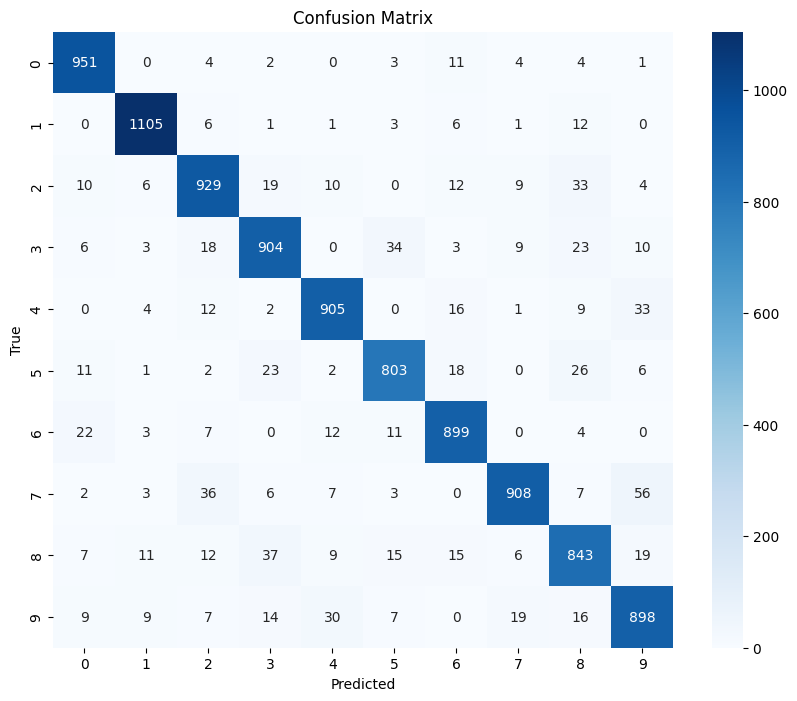

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.97      0.97      0.97      1135
           2       0.90      0.90      0.90      1032
           3       0.90      0.90      0.90      1010
           4       0.93      0.92      0.92       982
           5       0.91      0.90      0.91       892
           6       0.92      0.94      0.93       958
           7       0.95      0.88      0.91      1028
           8       0.86      0.87      0.86       974
           9       0.87      0.89      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000


Test Accuracy: 0.9145


In [29]:
# ============ CONFUSION MATRIX ============
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test_true, y_pred))

# Calculate accuracy
accuracy = (y_pred == y_test_true).mean()
print(f"\nTest Accuracy: {accuracy:.4f}")

Total misclassified: 855


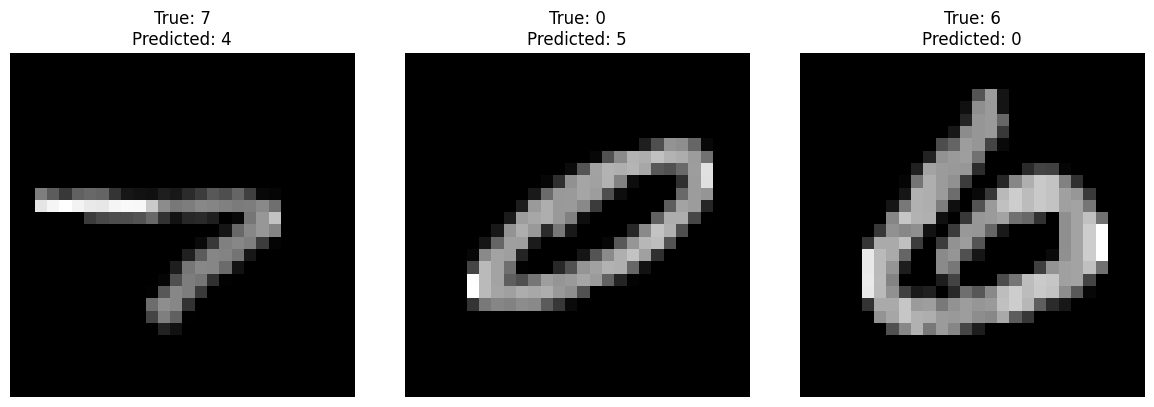

In [30]:
# Find misclassified examples
misclassified_idx = np.where(y_pred != y_test_true)[0]

print(f"Total misclassified: {len(misclassified_idx)}")

# Select 3 random misclassified examples
n_examples = min(3, len(misclassified_idx))
random_idx = np.random.choice(misclassified_idx, n_examples, replace=False)

# Plot the misclassified images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, idx in enumerate(random_idx):
    axes[i].imshow(X_test[idx].squeeze(), cmap='gray')
    axes[i].set_title(f"True: {y_test_true[idx]}\nPredicted: {y_pred[idx]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()